In [1]:
import scipy.io
import numpy as np

data = scipy.io.loadmat("BufferedHumanActivity.mat")
X = data['atx'].T
y = data['actid'].flatten()
actnames = [str(n[0]) for n in data['actnames'].flatten()]
fs = int(data['fs'].flatten()[0])

print("Forma de X:", X.shape)
print("Forma de y:", y.shape)
print("Nombres de actividades:", actnames)
print("Frecuencia de muestreo:", fs)

Forma de X: (7776, 44)
Forma de y: (7776,)
Nombres de actividades: ['Sitting', 'Standing', 'Walking', 'Running']
Frecuencia de muestreo: 10


In [2]:
from scipy.signal import butter, filtfilt

def highpass_filter(signal, cutoff=0.5, fs=fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, signal)

X_hp = np.array([highpass_filter(x) for x in X])

In [3]:
def temporal_features(x):
    mean_val = np.mean(x)
    rms = np.sqrt(np.mean(x**2))
    peak = np.max(np.abs(x))
    shape_factor = rms / np.mean(np.abs(x))
    crest_factor = peak / rms if rms != 0 else 0
    impulse_factor = peak / np.mean(np.abs(x)) if np.mean(np.abs(x)) != 0 else 0
    clearance_factor = peak / (np.mean(x**4)**0.25) if np.mean(x**4) != 0 else 0
    return [mean_val, rms, shape_factor, crest_factor, impulse_factor, clearance_factor]

from scipy.signal import welch

def frequency_features(x, fs):
    f, Pxx = welch(x, fs=fs, nperseg=len(x))
    freq_mean = np.sum(f * Pxx) / np.sum(Pxx)
    peak_idx = np.argmax(Pxx)
    peak_freq = f[peak_idx]
    peak_amp = Pxx[peak_idx]
    band_mask = (f >= 0.5) & (f <= 10)
    band_power = np.sum(Pxx[band_mask])
    threshold = 0.5 * peak_amp
    bw = f[Pxx > threshold]
    bw_width = bw[-1] - bw[0] if len(bw) > 1 else 0
    return [freq_mean, peak_freq, peak_amp, band_power, bw_width]

features = np.array([temporal_features(x) + frequency_features(x, fs) for x in X_hp])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_features = scaler.fit_transform(features)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.25, random_state=42, stratify=y
)

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC(decision_function_shape='ovr')
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto']}
grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

best_svm = grid.best_estimator_
print("Mejores hiperparámetros:", grid.best_params_)


Mejores hiperparámetros: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}


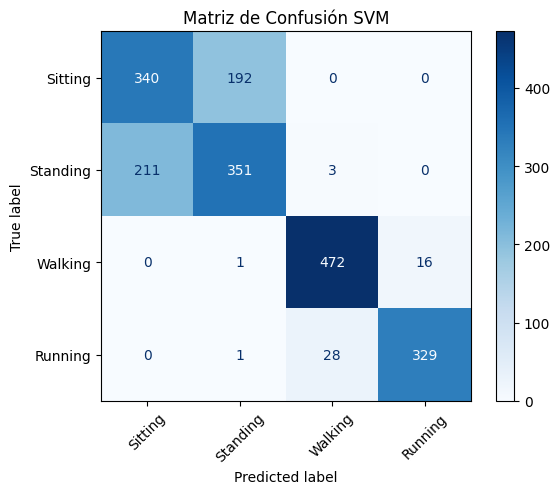

              precision    recall  f1-score   support

     Sitting     0.6171    0.6391    0.6279       532
    Standing     0.6440    0.6212    0.6324       565
     Walking     0.9384    0.9652    0.9516       489
     Running     0.9536    0.9190    0.9360       358

    accuracy                         0.7675      1944
   macro avg     0.7883    0.7861    0.7870      1944
weighted avg     0.7677    0.7675    0.7674      1944



In [7]:
y_pred = best_svm.predict(X_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actnames)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión SVM")
plt.show()

print(classification_report(y_test, y_pred, target_names=actnames, digits=4))